In [4]:
import numpy as np
import scipy as sp
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from skimage.transform import resize
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile as zf
import pandas as pd
# import cv2
# import PIL as pil

In [5]:
archive = zf.ZipFile('data/archive.zip')

metafile  = archive.open('Meta.csv')
testfile  = archive.open('Test.csv')
trainfile = archive.open('Train.csv')

meta  = pd.read_csv(metafile)
test  = pd.read_csv(testfile)
train = pd.read_csv(trainfile)

train_images = [ mpl.image.imread(archive.open(imfile)) for imfile in train.Path]
train_labels = np.array(train.ClassId)

test_images  = [ mpl.image.imread(archive.open(imfile)) for imfile in test.Path]
test_labels  = np.array(test.ClassId)

In [102]:
# NOTE: THESE FUNCTIONS CURRENTLY ONLY WORK ON ONE IMAGE AT A TIME
# (because trying to generalize was introducing sneaky bugs)

def only_ROI(img,roi):
    return img[ roi[1]:roi[3], roi[0]:roi[2] ]


def adjust_range(img):
    ''' Make sure all pixels are in range [0,255]'''
    initial_range = np.ptp(img)
    img /= initial_range
    img -= np.min(img)
    
    return img


def flatten(img, rgb2gray=False):
    # Convert image to grayscale first
    if rgb2gray:
        img = np.mean(img,axis=-1)
        
    img = np.reshape(img, (-1))
    
    return img


def process(img, resize_to=None, flat=True, rgb2gray=False):
    # Resize image to desired size
    if resize_to is not None:
        img = resize(img, resize_to) 
        
    # Rescale image to have all pixel values on [0,1]
    img = adjust_range(img)
    
    if flat:
        img = flatten(img, rgb2gray=rgb2gray)
    return img



# Crop to ROI
train_data = [only_ROI(img,roi) for img,roi    \
       in zip(train_images, train[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy())]
test_data  = [only_ROI(img,roi) for img,roi    \
       in zip(test_images,   test[['Roi.X1','Roi.Y1','Roi.X2', 'Roi.Y2']].to_numpy())]

# Resize all images to smallest in train set
shapes = np.array([im.shape for im in train_data])
resize_to = np.min(shapes,axis=0)
train_data = np.array([process(img, resize_to=resize_to, flat=True) for img in train_data])
test_data  = np.array([process(img, resize_to=resize_to, flat=True) for img in test_data]) 

# Standardize each feature across all samples
train_data -= np.mean(train_data,axis=0) / np.std(train_data,axis=0)
test_data -= np.mean(test_data,axis=0) / np.std(test_data,axis=0)

0.086180516
0.09570788
0.097337306
0.090260394
0.09397617
0.08910182
0.08840079
0.093912825
0.09721835
0.08573313
0.09002552
0.095209986
0.08608193
0.08150637
0.080907844
0.09235379
0.051830072
0.05307189
0.05647059
0.06203922
0.05704575
0.060200438
0.057254814
0.058534704
0.056665443
0.06052403
0.060810313
0.061078377
0.05609192
0.06289579
0.06352805
0.0591347
0.05899563
0.07947713
0.0947974
0.08363413
0.07669754
0.08257325
0.07538818
0.07480402
0.076607004
0.08831373
0.09464054
0.08669281
0.0908584
0.09019607
0.08496733
0.09346408
0.089411706
0.094117455
0.09019413
0.09170544
0.09613837
0.09463682
0.092607066
0.09951289
0.0970099
0.09512209
0.09612165
0.09159769
0.0974052
0.08973523
0.09487234
0.08846316
0.0947172
0.089841776
0.09797745
0.09059232
0.09327698
0.09208767
0.08846045
0.0852741
0.08074973
0.07794827
0.07827326
0.078306966
0.081045315
0.08004
0.07788789
0.07807671
0.07989928
0.07922385
0.084617384
0.079314545
0.08078867
0.08190049
0.07812631
0.078594394
0.077432886
0.07891

In [146]:
pca = skl.decomposition.PCA(n_components=0.95)
pca_train = pca.fit_transform(train_data)

In [342]:
# let's try an SVM

198

In [343]:
# k-NN classification
def img_dist(img1,img2,axis=-1):
    # note: don't do this with the whole dataset, memory error
    if np.ndim(img1)==2 and np.ndim(img2)==2:
        img1 = np.expand_dims(img1,1)
    return np.linalg.norm(img1-img2,axis=axis)
    
def get_neighbors(test,train,train_labels,k=5):
    if np.ndim(test)<2:
        neighbors = np.empty(k,dtype=int)
        d = img_dist(test,train)
        neighbors = np.argpartition(d, k)[:k]
        labels = train_labels[neighbors[i]]
    else:
        neighbors = -np.ones((len(test),k),dtype=int) # fill with invalid value -1
        labels    = np.empty((neighbors.shape), dtype=int)
        for i,test_img in enumerate(test):
            d = img_dist(test_img,train)
            neighbors[i] = np.argpartition(d, k)[:k]
            labels[i] = train_labels[neighbors[i]]
            
    return neighbors, labels

def majority(lbl):
    u,ind = np.unique(lbl, return_inverse=True)
    mj = u[np.argmax(
        np.apply_along_axis(np.bincount, 1, ind.reshape(lbl.shape), 
                            None, np.max(ind)+1),
                     axis=1)
            ]
    return mj

def kNN(test,data,data_labels,k=5):
    N,lbl = get_neighbors(test=test,
                          train=data,
                          train_labels=data_labels,
                          k=k)
    classification = majority(lbl)
    
    return classification


test_n = 1000  
k = 5 #int(np.sqrt(len(train_data)))

sample_inds = np.random.choice(test.shape[0], test_n, replace=False)
test_sample = pca_test[sample_inds]
test_label_slice = test_labels[sample_inds]

kNN_classification = kNN(test=test_sample,
                         data=pca_train,
                         data_labels=train_labels,
                         k=k)   

predicted_test_labels = kNN_classification



In [353]:
train_slice.shape

(39209, 10)

In [357]:
test_n = 1000
k = 5 #int(np.sqrt(len(train_data)))

sample_inds = np.random.choice(pca_test.shape[0], test_n, replace=False)
n_components = 5


train_slice = pca_train[:,:n_components]
test_sample = pca_test[sample_inds,:n_components]
test_label_slice = test_labels[sample_inds]



for k in np.logspace(0,3,10):
    k = int(k)
    kNN_classification = kNN(test=test_sample,
                             data=train_slice,
                             data_labels=train_labels,
                             k=k)
    
    predicted_test_labels = kNN_classification
    cm = confusion_matrix(test_label_slice, predicted_test_labels)
    acc = accuracy_score(test_label_slice, predicted_test_labels) 
    print(k,acc)    

1 0.078
2 0.095
4 0.08
10 0.084
21 0.072
46 0.07
100 0.089
215 0.107
464 0.12
1000 0.108


In [344]:
dtree = DecisionTreeClassifier()

dtree.fit(pca_train, train_labels)


pca_test = pca.transform(test_data)

# predict labels using the trained classifier
predicted_test_labels = dtree.predict(pca_test)

In [547]:
predicted_test_labels = prediction
cm = confusion_matrix(test_labels, predicted_test_labels)

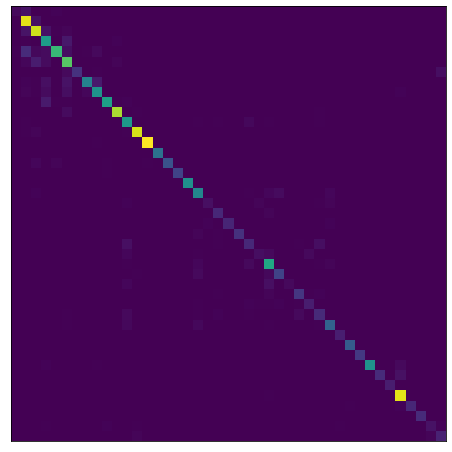

In [548]:
fig, ax = plt.subplots(1, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1),
                         facecolor='w')
ax.imshow(cm)

In [550]:
accuracy_score(test_labels, predicted_test_labels) 

0.8620744259699129

In [553]:
# exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

# plt.figure(figsize=(10,5), facecolor='white')
# plt.bar(range(len(exp_var_cumul)), exp_var_cumul)

bop = np.ones((4,6,9))
bop.shape[-1]

9

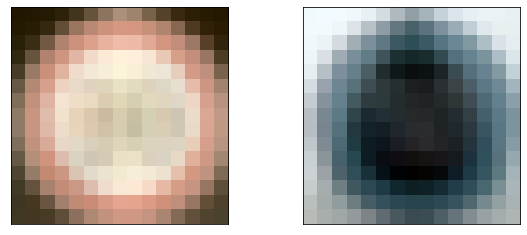

In [527]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(adjust_range(pca.components_[i].reshape(15, 15,3)))


# LDA

31222321.47846746
10096235.300015304
5890941.614645291
4069120.4497074597
3223403.067854356
2671718.725741174
2158501.1471470445
1925464.8681038693
1686563.3372239023
1473987.5980385803


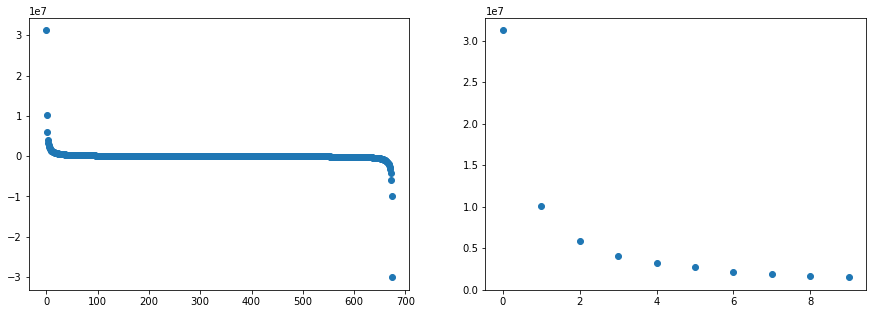

In [538]:
def mean_vecs(data, labels):
    classes = np.unique(labels)
    vec = np.empty( (len(classes),data.shape[1]) )
    for i,c in enumerate(classes):
        mask = (labels==c)
        vec[i] = np.mean(data[mask],axis=0)
    return vec

def bc_scatter(data, labels, means):
    classes = np.unique(labels)
    scatter = np.zeros( (data.shape[1],data.shape[1]) )
    for i,cl in enumerate(classes):
        # Get number of data points in class
        N = np.count_nonzero(labels==cl)
        # Get cross-class means
        M = np.mean(data,axis=0)
        # Calculate scatter from mean in class
        spread = means[i] - M
        per_class = N*(spread.T).dot(spread)
        scatter += per_class
    return scatter


def wc_scatter(data, labels, means):
    classes = np.unique(labels)
    scatter = np.zeros( (data.shape[1],data.shape[1]) )
    for i,cl in enumerate(classes):
        # Get data points in class
        mask = (labels==cl)
        in_class = data[mask]
        N = len(in_class)
        # Calculate scatter in class
        spread = in_class - means[i]
        per_class = (spread.T).dot(spread)/(N-1) # account for diff. class sizes
        scatter += per_class
    return scatter
        

def scatter_mats(data,labels,means):
    return wc_scatter(data,labels,means), bc_scatter(data,labels,means)
    
    
X = train_data
y = train_labels
X_test = test_data
    
means = mean_vecs(X,y)
Sw,Sb = scatter_mats(X, y, means)
eigenvals, eigenvecs = sp.linalg.eigh(np.linalg.inv(Sw).dot(Sb))        

# # Use magnitude of complex eigenvalues
# eigenvals = np.abs(eigenvals)

# Sort from highest eigenvalue to lowest
order = eigenvals.argsort()[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:,order]


# Plot how the eigenvalues drop off
fig,ax = plt.subplots(ncols=2,figsize=(15,5), facecolor='w')
ax = ax.ravel()
n_ev = 10
ax[0].plot(range(len(eigenvals)),eigenvals,'o')
ax[1].plot(range(n_ev),eigenvals[:n_ev],'o')

for i in range(n_ev):
    print(eigenvals[i])

In [531]:
# print('Variance explained:\n')
# ev_sum = sum(eigenvals)
# for i,eigs in enumerate(zip(eigenvals,eigenvecs)):
#     print('Eigenvalue {0:}: {1:.2%}'.format(i+1, (eigs[0]/ev_sum).real))

Variance explained:

Eigenvalue 1: 2281.79%
Eigenvalue 2: 737.85%
Eigenvalue 3: 430.52%
Eigenvalue 4: 297.38%
Eigenvalue 5: 235.57%
Eigenvalue 6: 195.25%
Eigenvalue 7: 157.75%
Eigenvalue 8: 140.72%
Eigenvalue 9: 123.26%
Eigenvalue 10: 107.72%
Eigenvalue 11: 101.06%
Eigenvalue 12: 93.60%
Eigenvalue 13: 85.00%
Eigenvalue 14: 77.97%
Eigenvalue 15: 73.60%
Eigenvalue 16: 66.86%
Eigenvalue 17: 65.07%
Eigenvalue 18: 59.25%
Eigenvalue 19: 56.55%
Eigenvalue 20: 54.13%
Eigenvalue 21: 51.44%
Eigenvalue 22: 49.02%
Eigenvalue 23: 48.13%
Eigenvalue 24: 45.01%
Eigenvalue 25: 43.76%
Eigenvalue 26: 40.03%
Eigenvalue 27: 39.42%
Eigenvalue 28: 38.27%
Eigenvalue 29: 37.56%
Eigenvalue 30: 37.09%
Eigenvalue 31: 34.92%
Eigenvalue 32: 32.92%
Eigenvalue 33: 32.49%
Eigenvalue 34: 32.45%
Eigenvalue 35: 30.44%
Eigenvalue 36: 29.17%
Eigenvalue 37: 28.95%
Eigenvalue 38: 28.29%
Eigenvalue 39: 27.27%
Eigenvalue 40: 26.52%
Eigenvalue 41: 25.05%
Eigenvalue 42: 24.93%
Eigenvalue 43: 24.71%
Eigenvalue 44: 24.28%
Eigenval

In [532]:
# I will use first 3 eigens, since that's where they start to level off
my_evals = eigenvals# [:3]
my_evecs = eigenvecs# [:3].T
my_evecs.shape

(675, 675)

In [534]:
# Apply LDA matrix
lda_train = X.dot(my_evecs)
lda_test  = X_test.dot(my_evecs)

In [539]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)


SVC()

In [544]:
prediction = clf.predict(X_test)

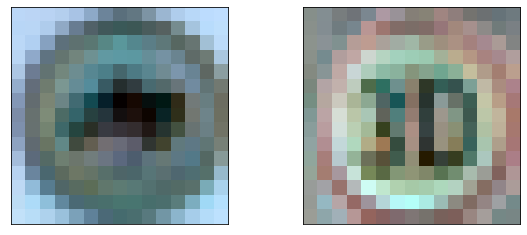

In [557]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1),
                         facecolor='w')
for i, ax in enumerate(axes.flat):
    ax.imshow(adjust_range(X_test[i,:].reshape(15, 15,3)))


In [554]:
X.shape

(39209, 675)